# Model training

In [1]:
from sklearn.model_selection import GridSearchCV
from sklearn import model_selection
from sklearn.preprocessing import StandardScaler

from utils import data_loaders
from utils.model_evaluation import evaluate_model

## Loading data

I start with reading data processed in the previous notebook.

In [2]:
member_transactions = data_loaders.load_member_transactions(
    "data/processed_member_transactions.csv")

Now I read churn information and split the dataset into train-test pairs.

In [3]:
churn = data_loaders.load_train_churn("data/train_v2.csv")
kkbox = churn.merge(member_transactions, on="user_id", how="inner")
kkbox.drop_duplicates(inplace=True)
kkbox = kkbox.set_index("user_id")

## Train-test split

First, I separate input data and targets, then I scale the values using standard scaler.

In [4]:
X = kkbox.drop(["is_churn"], axis=1)
print(f"Total dataset size: {len(X):,}")
y = kkbox["is_churn"].to_numpy()

X = StandardScaler().fit_transform(X)
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, 
                                                                    y, 
                                                                    test_size=0.3,
                                                                    random_state=50)

print(f"Train size: {len(X_train):,}, test size: {len(X_test):,}")

Total dataset size: 1,001,430
Train size: 701,001, test size: 300,429


## Cross-validation settings

Throughout the training, I will be using CV with 3 splits.

In [4]:
kfold = model_selection.KFold(n_splits=3, shuffle=True)

# Classification models

Since the goal of this project is to predict whether or not a customer will leave the serice (binary decision), I will be using different classifying models.

## Logistic Regression Classifier

First, I'm trying a simple logisitc regression classifier. I'm searching through different $C$ values using grid search.

In [7]:
from sklearn.linear_model import LogisticRegression

logistic_grid = GridSearchCV(
    LogisticRegression(max_iter=1000),
    param_grid={
        "C": [1e-3, 1e-2, 1e-1, 1.0, 10.0, 1e2, 1e3]
    },
    cv=kfold,
    refit=True,
    verbose=3
)

logistic_grid.fit(X_train, y_train)

Fitting 3 folds for each of 7 candidates, totalling 21 fits
[CV] C=0.001 .........................................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ............................. C=0.001, score=0.922, total=   2.3s
[CV] C=0.001 .........................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.3s remaining:    0.0s


[CV] ............................. C=0.001, score=0.923, total=   2.6s
[CV] C=0.001 .........................................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    5.0s remaining:    0.0s


[CV] ............................. C=0.001, score=0.922, total=   3.1s
[CV] C=0.01 ..........................................................
[CV] .............................. C=0.01, score=0.922, total=   3.6s
[CV] C=0.01 ..........................................................
[CV] .............................. C=0.01, score=0.923, total=   3.1s
[CV] C=0.01 ..........................................................
[CV] .............................. C=0.01, score=0.922, total=   3.0s
[CV] C=0.1 ...........................................................
[CV] ............................... C=0.1, score=0.922, total=   3.8s
[CV] C=0.1 ...........................................................
[CV] ............................... C=0.1, score=0.923, total=   2.9s
[CV] C=0.1 ...........................................................
[CV] ............................... C=0.1, score=0.922, total=   3.0s
[CV] C=1.0 ...........................................................
[CV] .

[Parallel(n_jobs=1)]: Done  21 out of  21 | elapsed:  1.4min finished


GridSearchCV(cv=KFold(n_splits=3, random_state=None, shuffle=True),
             error_score=nan,
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=1000, multi_class='auto',
                                          n_jobs=None, penalty='l2',
                                          random_state=None, solver='lbfgs',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='deprecated', n_jobs=None,
             param_grid={'C': [0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=3)

Best score: 0.9224751462551408
Best params: {'C': 0.01}
F1 score: 0.454
Precision score: 0.751
Recall score: 0.325


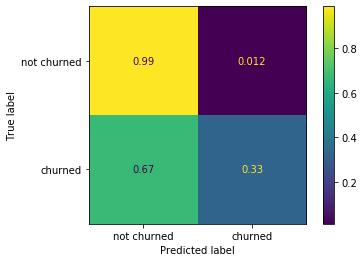

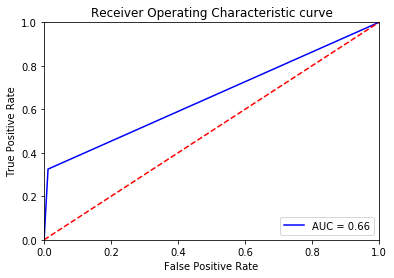

In [8]:
evaluate_model(logistic_grid, X_test, y_test)

The best score of this model is similar to that of a random guess, and its F1 and recall scores are really low, which suggest that the imbalanced data really influenced the results.

## Random Forest Classifier

In [7]:
from sklearn.tree import DecisionTreeClassifier

dc_grid = GridSearchCV(
    DecisionTreeClassifier(),
    param_grid={
        "max_depth": [None, 10, 100, 1000, 10000]
    },
    cv=kfold,
    refit=True,
    verbose=2
)

dc_grid.fit(X_train, y_train)

Fitting 3 folds for each of 5 candidates, totalling 15 fits
[CV] max_depth=None ..................................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ................................... max_depth=None, total=   5.4s
[CV] max_depth=None ..................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    5.4s remaining:    0.0s


[CV] ................................... max_depth=None, total=   5.7s
[CV] max_depth=None ..................................................
[CV] ................................... max_depth=None, total=   5.5s
[CV] max_depth=10 ....................................................
[CV] ..................................... max_depth=10, total=   3.6s
[CV] max_depth=10 ....................................................
[CV] ..................................... max_depth=10, total=   3.5s
[CV] max_depth=10 ....................................................
[CV] ..................................... max_depth=10, total=   3.6s
[CV] max_depth=100 ...................................................
[CV] .................................... max_depth=100, total=   5.7s
[CV] max_depth=100 ...................................................
[CV] .................................... max_depth=100, total=   5.9s
[CV] max_depth=100 ...................................................
[CV] .

[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:  1.3min finished


GridSearchCV(cv=KFold(n_splits=3, random_state=None, shuffle=True),
             error_score=nan,
             estimator=DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              presort='deprecated',
                                              random_state=None,
                                              splitter='best'),
             iid='deprecated', n_jobs=None,
             par

Best score: 0.9275008166892772
Best params: {'max_depth': 10}
F1 score: 0.482
Precision score: 0.825
Recall score: 0.34


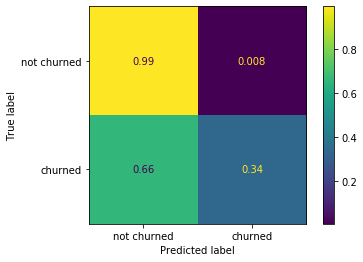

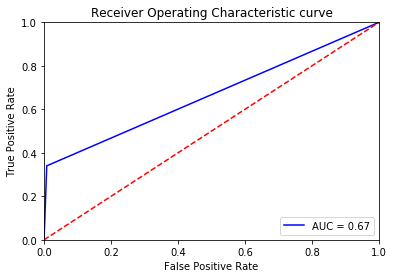

In [8]:
evaluate_model(dc_grid, X_test, y_test)

Decision tree classifier performed similarly to the previous classifier - it could not handle imbalanced classes.

# Imbalanced data

Since it's been problematic to find a good classifier so far, I decided to try to balance the two classes (churned and not-churned users).

## Strategy: Weighted Decision Tree Classifier

In [17]:
from sklearn.tree import DecisionTreeClassifier

wdc_grid = GridSearchCV(
    DecisionTreeClassifier(class_weight="balanced"),
    param_grid={
        "max_depth": [None, 10, 100, 1000, 10000]
    },
    cv=kfold,
    refit=True,
    verbose=3
)

wdc_grid.fit(X_train, y_train)

Fitting 3 folds for each of 5 candidates, totalling 15 fits
[CV] max_depth=None ..................................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ...................... max_depth=None, score=0.849, total=   8.5s
[CV] max_depth=None ..................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    8.5s remaining:    0.0s


[CV] ...................... max_depth=None, score=0.851, total=  11.2s
[CV] max_depth=None ..................................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   19.7s remaining:    0.0s


[CV] ...................... max_depth=None, score=0.852, total=   6.6s
[CV] max_depth=10 ....................................................
[CV] ........................ max_depth=10, score=0.799, total=   4.8s
[CV] max_depth=10 ....................................................
[CV] ........................ max_depth=10, score=0.783, total=   4.1s
[CV] max_depth=10 ....................................................
[CV] ........................ max_depth=10, score=0.810, total=   4.6s
[CV] max_depth=100 ...................................................
[CV] ....................... max_depth=100, score=0.849, total=   8.1s
[CV] max_depth=100 ...................................................
[CV] ....................... max_depth=100, score=0.851, total=   6.2s
[CV] max_depth=100 ...................................................
[CV] ....................... max_depth=100, score=0.851, total=   9.4s
[CV] max_depth=1000 ..................................................
[CV] .

[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:  1.7min finished


GridSearchCV(cv=KFold(n_splits=3, random_state=None, shuffle=True),
             error_score=nan,
             estimator=DecisionTreeClassifier(ccp_alpha=0.0,
                                              class_weight='balanced',
                                              criterion='gini', max_depth=None,
                                              max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              presort='deprecated',
                                              random_state=None,
                                              splitter='best'),
        

Best score: 0.8504324530207518
Best params: {'max_depth': None}
F1 score: 0.422
Precision score: 0.338
Recall score: 0.562


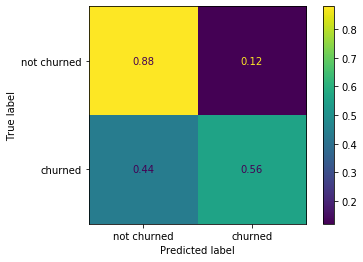

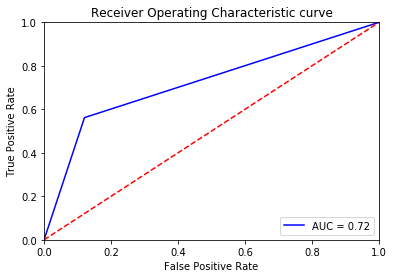

In [18]:
evaluate_model(wdc_grid, X_test, y_test)

Compared to unweighted decision tree, a balanced tree performs a little bit better on recall, although its F1 and precision scores are lower.

## Strategy: Weighted Random Forest Classifier

In [19]:
from sklearn.ensemble import RandomForestClassifier

wrf_grid = GridSearchCV(
    RandomForestClassifier(),
    param_grid={
        "n_estimators": [10, 100],
        "max_depth": [None, 10, 100, 1000],
        "class_weight": ["balanced", "balanced_subsample"]
    },
    cv=kfold,
    refit=True,
    verbose=3
)

wrf_grid.fit(X_train, y_train)

Fitting 3 folds for each of 16 candidates, totalling 48 fits
[CV] class_weight=balanced, max_depth=None, n_estimators=10 ..........


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  class_weight=balanced, max_depth=None, n_estimators=10, score=0.873, total=  13.2s
[CV] class_weight=balanced, max_depth=None, n_estimators=10 ..........


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   13.2s remaining:    0.0s


[CV]  class_weight=balanced, max_depth=None, n_estimators=10, score=0.873, total=  12.1s
[CV] class_weight=balanced, max_depth=None, n_estimators=10 ..........


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   25.3s remaining:    0.0s


[CV]  class_weight=balanced, max_depth=None, n_estimators=10, score=0.874, total=  11.2s
[CV] class_weight=balanced, max_depth=None, n_estimators=100 .........
[CV]  class_weight=balanced, max_depth=None, n_estimators=100, score=0.868, total= 1.8min
[CV] class_weight=balanced, max_depth=None, n_estimators=100 .........
[CV]  class_weight=balanced, max_depth=None, n_estimators=100, score=0.869, total= 2.3min
[CV] class_weight=balanced, max_depth=None, n_estimators=100 .........
[CV]  class_weight=balanced, max_depth=None, n_estimators=100, score=0.870, total= 1.5min
[CV] class_weight=balanced, max_depth=10, n_estimators=10 ............
[CV]  class_weight=balanced, max_depth=10, n_estimators=10, score=0.817, total=   4.7s
[CV] class_weight=balanced, max_depth=10, n_estimators=10 ............
[CV]  class_weight=balanced, max_depth=10, n_estimators=10, score=0.784, total=   4.9s
[CV] class_weight=balanced, max_depth=10, n_estimators=10 ............
[CV]  class_weight=balanced, max_depth=10

[Parallel(n_jobs=1)]: Done  48 out of  48 | elapsed: 40.6min finished


GridSearchCV(cv=KFold(n_splits=3, random_state=None, shuffle=True),
             error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                              oob_sc

Best score: 0.8737776408307548
Best params: {'class_weight': 'balanced', 'max_depth': 100, 'n_estimators': 10}
F1 score: 0.447
Precision score: 0.387
Recall score: 0.529


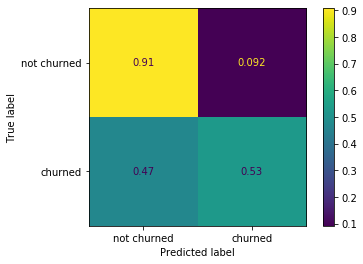

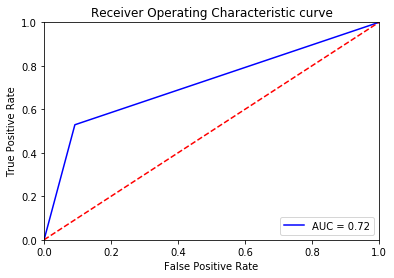

In [21]:
evaluate_model(wrf_grid, X_test, y_test)

## Strategy: undersampling

Before running a classifiers, I will undersample of the majority class - in this case, I will sample fewer users that did not churn.

In [5]:
import pandas as pd


churned = kkbox[kkbox["is_churn"] == 1]
not_churned = kkbox[kkbox["is_churn"] == 0]
max_sample_count = len(churned)
sample_count = int(0.7 * max_sample_count)

churned_sample = churned.sample(sample_count)
not_churned_sample = not_churned.sample(sample_count)
kkbox_balanced = pd.concat([churned_sample, not_churned_sample])

X_balanced = kkbox_balanced.drop(["is_churn"], axis=1)
print(f"Total dataset size: {len(X_balanced):,}")
y_balanced = kkbox_balanced["is_churn"].to_numpy()

X_balanced = StandardScaler().fit_transform(X_balanced)
X_train_balanced, X_test_balanced, y_train_balanced, y_test_balanced = model_selection.train_test_split(
    X_balanced, y_balanced, test_size=0.3, random_state=50)

print(f"Train size: {len(X_train_balanced):,}, test size: {len(X_test_balanced):,}")

Total dataset size: 138,520
Train size: 96,964, test size: 41,556


However, since the cardinality of the less popular class is so small, the total size of traing dataset shrinked over 7 times.

## Balanced Logistic Regression

In [9]:
from sklearn.linear_model import LogisticRegression

bl_grid = GridSearchCV(
    LogisticRegression(max_iter=1000),
    param_grid={
        "C": [1e-3, 1e-2, 1e-1, 1.0, 10.0, 1e2, 1e3]
    },
    cv=kfold,
    refit=True,
    verbose=3
)

bl_grid.fit(X_train_balanced, y_train_balanced)

Fitting 3 folds for each of 7 candidates, totalling 21 fits
[CV] C=0.001 .........................................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ............................. C=0.001, score=0.714, total=   0.3s
[CV] C=0.001 .........................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s remaining:    0.0s


[CV] ............................. C=0.001, score=0.714, total=   0.2s
[CV] C=0.001 .........................................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.5s remaining:    0.0s


[CV] ............................. C=0.001, score=0.711, total=   0.4s
[CV] C=0.01 ..........................................................
[CV] .............................. C=0.01, score=0.715, total=   0.4s
[CV] C=0.01 ..........................................................
[CV] .............................. C=0.01, score=0.715, total=   0.4s
[CV] C=0.01 ..........................................................
[CV] .............................. C=0.01, score=0.712, total=   0.3s
[CV] C=0.1 ...........................................................
[CV] ............................... C=0.1, score=0.717, total=   0.6s
[CV] C=0.1 ...........................................................
[CV] ............................... C=0.1, score=0.717, total=   0.7s
[CV] C=0.1 ...........................................................
[CV] ............................... C=0.1, score=0.713, total=   0.5s
[CV] C=1.0 ...........................................................
[CV] .

[Parallel(n_jobs=1)]: Done  21 out of  21 | elapsed:   10.3s finished


GridSearchCV(cv=KFold(n_splits=3, random_state=None, shuffle=True),
             error_score=nan,
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=1000, multi_class='auto',
                                          n_jobs=None, penalty='l2',
                                          random_state=None, solver='lbfgs',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='deprecated', n_jobs=None,
             param_grid={'C': [0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=3)

### Evaluation on balanced data

Best score: 0.7170702309072067
Best params: {'C': 100.0}
F1 score: 0.67
Precision score: 0.81
Recall score: 0.571


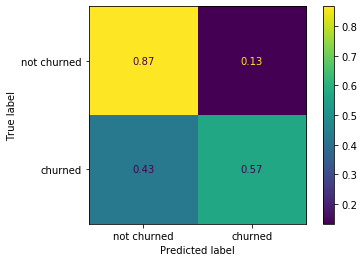

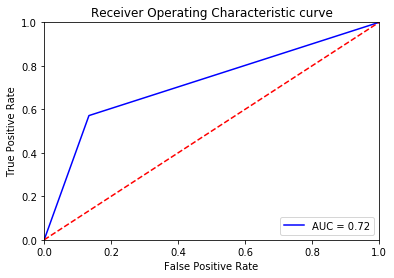

In [10]:
evaluate_model(bl_grid, X_test_balanced, y_test_balanced)

## Balanced Decision Tree Classifier

In [11]:
from sklearn.tree import DecisionTreeClassifier

bdc_grid = GridSearchCV(
    DecisionTreeClassifier(),
    param_grid={
        "max_depth": [None, 10, 100, 1000, 10000]
    },
    cv=kfold,
    refit=True,
    verbose=2
)

bdc_grid.fit(X_train_balanced, y_train_balanced)

Fitting 3 folds for each of 5 candidates, totalling 15 fits
[CV] max_depth=None ..................................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ................................... max_depth=None, total=   0.5s
[CV] max_depth=None ..................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.6s remaining:    0.0s


[CV] ................................... max_depth=None, total=   0.7s
[CV] max_depth=None ..................................................
[CV] ................................... max_depth=None, total=   0.6s
[CV] max_depth=10 ....................................................
[CV] ..................................... max_depth=10, total=   0.4s
[CV] max_depth=10 ....................................................
[CV] ..................................... max_depth=10, total=   0.4s
[CV] max_depth=10 ....................................................
[CV] ..................................... max_depth=10, total=   0.4s
[CV] max_depth=100 ...................................................
[CV] .................................... max_depth=100, total=   0.5s
[CV] max_depth=100 ...................................................
[CV] .................................... max_depth=100, total=   0.7s
[CV] max_depth=100 ...................................................
[CV] .

[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:    8.7s finished


GridSearchCV(cv=KFold(n_splits=3, random_state=None, shuffle=True),
             error_score=nan,
             estimator=DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              presort='deprecated',
                                              random_state=None,
                                              splitter='best'),
             iid='deprecated', n_jobs=None,
             par

Best score: 0.7660368703636743
Best params: {'max_depth': 10}
F1 score: 0.762
Precision score: 0.785
Recall score: 0.74


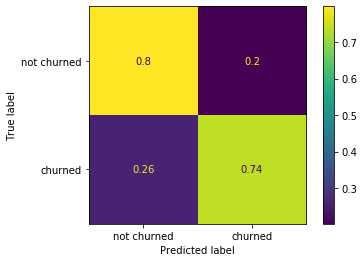

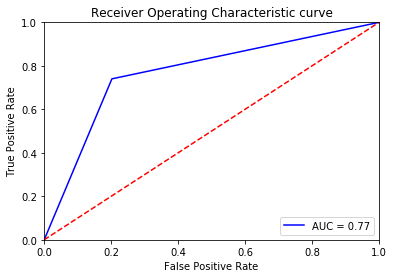

In [12]:
evaluate_model(bdc_grid, X_test_balanced, y_test_balanced)

## Balanced Random Forest Classifier

In [14]:
from sklearn.ensemble import RandomForestClassifier

brf_grid = GridSearchCV(
    RandomForestClassifier(),
    param_grid={
        "max_depth": [None, 10, 100, 1000],
        "n_estimators": [10, 100, 1000]
    },
    cv=kfold,
    refit=True,
    verbose=3
)

brf_grid.fit(X_train_balanced, y_train_balanced)

Fitting 3 folds for each of 12 candidates, totalling 36 fits
[CV] max_depth=None, n_estimators=10 .................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ..... max_depth=None, n_estimators=10, score=0.736, total=   1.7s
[CV] max_depth=None, n_estimators=10 .................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.7s remaining:    0.0s


[CV] ..... max_depth=None, n_estimators=10, score=0.739, total=   1.6s
[CV] max_depth=None, n_estimators=10 .................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    3.3s remaining:    0.0s


[CV] ..... max_depth=None, n_estimators=10, score=0.737, total=   1.7s
[CV] max_depth=None, n_estimators=100 ................................
[CV] .... max_depth=None, n_estimators=100, score=0.734, total=  16.9s
[CV] max_depth=None, n_estimators=100 ................................
[CV] .... max_depth=None, n_estimators=100, score=0.737, total=  14.3s
[CV] max_depth=None, n_estimators=100 ................................
[CV] .... max_depth=None, n_estimators=100, score=0.733, total=  13.8s
[CV] max_depth=None, n_estimators=1000 ...............................
[CV] ... max_depth=None, n_estimators=1000, score=0.734, total= 2.3min
[CV] max_depth=None, n_estimators=1000 ...............................
[CV] ... max_depth=None, n_estimators=1000, score=0.737, total= 2.3min
[CV] max_depth=None, n_estimators=1000 ...............................
[CV] ... max_depth=None, n_estimators=1000, score=0.735, total= 2.3min
[CV] max_depth=10, n_estimators=10 ...................................
[CV] .

[Parallel(n_jobs=1)]: Done  36 out of  36 | elapsed: 28.1min finished


GridSearchCV(cv=KFold(n_splits=3, random_state=None, shuffle=True),
             error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                              oob_sc

Best score: 0.7579205056922845
Best params: {'max_depth': 10, 'n_estimators': 100}
F1 score: 0.755
Precision score: 0.771
Recall score: 0.74


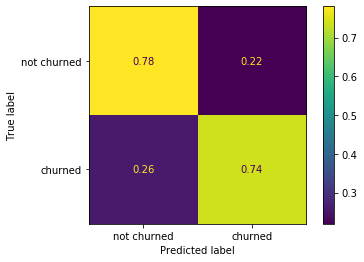

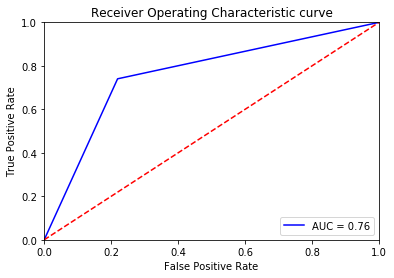

In [15]:
evaluate_model(brf_grid, X_test_balanced, y_test_balanced)

## Balanced K-Nearnest Neighbors Classifier

In [18]:
from sklearn.neighbors import KNeighborsClassifier

bknn_grid = GridSearchCV(
    KNeighborsClassifier(),
    param_grid={
        "n_neighbors": [3, 5, 10, 20],
        "weights": ["uniform", "distance"]
    },
    cv=kfold,
    refit=True,
    verbose=3
)

bknn_grid.fit(X_train_balanced, y_train_balanced)

Fitting 3 folds for each of 8 candidates, totalling 24 fits
[CV] n_neighbors=3, weights=uniform ..................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ...... n_neighbors=3, weights=uniform, score=0.732, total= 4.8min
[CV] n_neighbors=3, weights=uniform ..................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  4.8min remaining:    0.0s


[CV] ...... n_neighbors=3, weights=uniform, score=0.735, total= 4.5min
[CV] n_neighbors=3, weights=uniform ..................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  9.3min remaining:    0.0s


[CV] ...... n_neighbors=3, weights=uniform, score=0.734, total= 4.1min
[CV] n_neighbors=3, weights=distance .................................
[CV] ..... n_neighbors=3, weights=distance, score=0.725, total= 4.6min
[CV] n_neighbors=3, weights=distance .................................
[CV] ..... n_neighbors=3, weights=distance, score=0.728, total= 4.4min
[CV] n_neighbors=3, weights=distance .................................
[CV] ..... n_neighbors=3, weights=distance, score=0.728, total= 4.4min
[CV] n_neighbors=5, weights=uniform ..................................
[CV] ...... n_neighbors=5, weights=uniform, score=0.743, total= 4.6min
[CV] n_neighbors=5, weights=uniform ..................................
[CV] ...... n_neighbors=5, weights=uniform, score=0.749, total= 4.5min
[CV] n_neighbors=5, weights=uniform ..................................
[CV] ...... n_neighbors=5, weights=uniform, score=0.741, total= 4.4min
[CV] n_neighbors=5, weights=distance .................................
[CV] .

[Parallel(n_jobs=1)]: Done  24 out of  24 | elapsed: 105.3min finished


GridSearchCV(cv=KFold(n_splits=3, random_state=None, shuffle=True),
             error_score=nan,
             estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30,
                                            metric='minkowski',
                                            metric_params=None, n_jobs=None,
                                            n_neighbors=5, p=2,
                                            weights='uniform'),
             iid='deprecated', n_jobs=None,
             param_grid={'n_neighbors': [3, 5, 10, 20],
                         'weights': ['uniform', 'distance']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=3)

Best score: 0.7594468154781703
Best params: {'n_neighbors': 20, 'weights': 'uniform'}
F1 score: 0.753
Precision score: 0.802
Recall score: 0.711


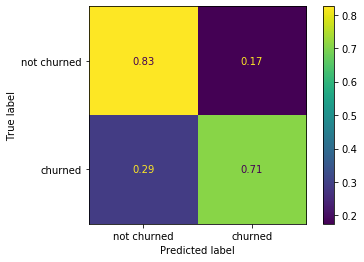

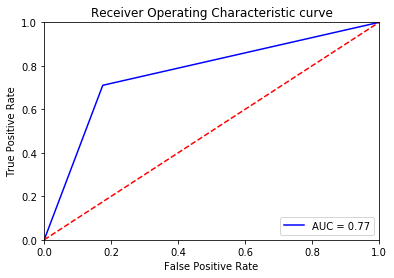

In [19]:
evaluate_model(bknn_grid, X_test_balanced, y_test_balanced)